# The Geography of Startup Success: The Effect of Proximity To Elite Universities On Startups' Growth and Investment. 
### by Jessica Dowuona-Owoo

### Introduction

It is almost intuitive to believe there is some form of significance to startups of being located near a university. The location of a startup is one of the most important endogenous factors that businesses consider, and this paper seeks to determine the relationship between proximity to top-tier universities and start-up investment success.

Many studies have been done focusing on a particular relationship between universities and startups (or innovation), for example, determining the role universities specialized in technical fields, say engineering and applied science (Bonaccorsi et al., 2013), have on startup creation or start-up operations in general (Fritsch & Aamoucke, 2017). Other studies show positive spillovers between research universities and innovation by providing research and development (R&D) initiatives (Anselin et al., 1997). Additionally, some papers show an opposing correlation to fields of study that may have been seen to be the more attractive (Audretsch et al., 2005). Further studies also look at the role of access to knowledge bases in determining the type of startups that are created in the area (Baptista et al., 2010).

To research this question, we will use a startup investments data set (Justinas Cirtautas, 2020), which contains information on start-ups from 1980 to 2014, and United States (US) university data (Work WIth Data, 2025), which includes ranking, population, founding year and other information about universities. The focus of this paper is to look at the US. Thus, we will consider universities and startups in the US. With this data we will explore the relationship between proximity and investment success. With the insights gained from this paper, startups may be able to make more informed decisions in the early stages of their life span.

In [38]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [39]:
! pip install stargazer

In [40]:
pip install us

Note: you may need to restart the kernel to use updated packages.


In [41]:
import matplotlib
import matplotlib.colors as mplc
import matplotlib.patches as patches
import geopandas as gpd
import pandas as pd
import us
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.colors as mcolors
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

from geopy.distance import geodesic

from shapely.geometry import Point


In [42]:
#Data from the Startups data set
objects = pd.read_csv('/Users/jessyterlisner/Desktop/ECO225Project/Data/objects.csv', low_memory=False)
investments = pd.read_csv('/Users/jessyterlisner/Desktop/ECO225Project/Data/investments.csv')
office = pd.read_csv('/Users/jessyterlisner/Desktop/ECO225Project/Data/offices.csv')
f_rounds = pd.read_csv('/Users/jessyterlisner/Desktop/ECO225Project/Data/funding_rounds.csv')
ipos = pd.read_csv('/Users/jessyterlisner/Desktop/ECO225Project/Data/ipos.csv')

# renaming values
objects.rename(columns={'id':'funded_object_id'}, inplace=True)
f_rounds.rename(columns={'object_id':'funded_object_id'}, inplace=True)
office.rename(columns={'object_id':'funded_object_id'}, inplace=True)
ipos.rename(columns={'object_id':'funded_object_id'}, inplace=True)

#dropping columns as they become duplicates in the main source file
office = office.drop(columns= ['created_at', 'updated_at', 'country_code', 'state_code', 'region', 'city'], inplace=False)
obj = objects.drop(columns= ['created_at', 'updated_at', 'tag_list', 'logo_height', 'logo_width', 'logo_url', 'created_by', 
                             'twitter_username', 'homepage_url'], inplace= False)
inv = investments.drop(columns= ['created_at', 'updated_at'], inplace=False)
f_rounds = f_rounds.drop(columns = ['source_description', 'created_at', 'updated_at', 'created_by', 'pre_money_valuation', 
                                    'raised_amount','post_money_valuation', 'post_money_currency_code', 
                                    'pre_money_valuation', 'pre_money_currency_code'], inplace=False)


In [43]:
#Merge source files
source = pd.merge(obj, inv, on= 'funded_object_id')
source_funds = pd.merge(source, f_rounds, on= 'funded_object_id')

In [44]:
#Choosing only USA data
source_usa = source_funds[source_funds["country_code"] == "USA"]

#merge offices and source usa to gain location data 
main = pd.merge(source_usa, office, on= 'funded_object_id')
main = main.drop_duplicates(subset=['funded_object_id']) # reduce duplication and keep only one office per startup.
main = main.dropna(subset = ['latitude' , 'longitude'])

# Drop duplicate columns
main = main.loc[:, ~main.columns.duplicated()]
main.columns
main = pd.merge(main, ipos, on='funded_object_id', suffixes=('_main', '_ipos'))

In [45]:
#Data from the additional data set 
uni = pd.read_csv('/Users/jessyterlisner/Desktop/ECO225Project/Data/Universities, the United States.csv')
uni = uni.dropna(subset = ['latitude' , 'longitude'])
uni.head()

,university,country,domain,city,ranking,address,foundation year,description,total students,undergraduate students,graduate students,international students,latitude,longitude,logo link
0,"Texas A&M University, College Station",United States,tamu.edu,College Station,163,George Bush Drive,1876.0,Scope. The flagship of the 18-member Texas A&M...,73267.0,56527.0,16740.0,5861.0,30.627777,-96.334170,https://www.shanghairanking.cn/_uni/logo/df034...
1,Ohio State University,United States,osu.edu,Columbus,68,"Student Academic Services Building, 281 W. Lan...",1870.0,"Since 1870, The Ohio State University has been...",61492.0,50293.0,11199.0,7173.0,39.961113,-82.998886,https://www.shanghairanking.cn/_uni/logo/1ccdf...
2,University of Texas at Arlington,United States,uta.edu,Arlington,707,NaN,NaN,NaN,60035.0,42763.0,17272.0,9005.0,32.735554,-97.107780,https://www.shanghairanking.cn/_uni/logo/7c212...
3,New York University,United States,nyu.edu,New York,27,"New York University, 70 Washington Square Sout...",1831.0,NaN,58091.0,29902.0,28189.0,19170.0,40.714170,-74.006386,https://www.shanghairanking.cn/_uni/logo/d254e...
4,University of Central Florida,United States,ucf.edu,Florida,479,4000 Central Florida Blvd.,1963.0,The University of Central Florida (UCF) is a p...,56740.0,51717.0,5023.0,2476.0,18.365278,-66.567500,https://www.shanghairanking.cn/_uni/logo/813d8...


### Variable decisions
The chosen Y variable is investment success- expressed in values such as the average funding rounds, the value of investment raised. With our current data set, these are convenient and easy to calculate-investment success measures. They are also relatively easy to interpret for example, higher average funding rounds can be indicative of increased investor-investee interactions.

For the x values, we will consider the number of startups per state, the proximity to elite universities, entity type (company, person…), the category of the startup, the city (industry hot-spot), and the number of high-ranking universities in the city. The number of startups per state tells us the density of startups between states, and studying this x variable may help us discover whether or not the concentration of startups is helpful or detrimental to the average funds that each startup receives. The city (industry hot-spot) variable helps us analyze and account for skewed data for example California as a technology hot spot may suggest companies that are in similar or related fields that are located there may benefit from better-skilled workers, and possibly better funding. This is closely related to the next x variable; the category of the startup. There may be disparities between categories of entities and this may influence investment success. The number of high-ranking universities in the city is a necessary variable as it alerts us as to whether or not we can directly answer the research question for those US cities as the research question is focused on top-tier universities.

### Summary Statistics

In [48]:
#Summary Stats
summary = main.describe().T
summary = summary.loc[['investment_rounds', 'invested_companies', 'funding_rounds', 'funding_total_usd', 'milestones']]
summary.head()

,count,mean,std,min,25%,50%,75%,max
investment_rounds,255.0,1.239216e+00,7.007422e+00,0.0,0.0,0.0,0.0,8.900000e+01
invested_companies,255.0,1.039216e+00,5.798998e+00,0.0,0.0,0.0,0.0,7.300000e+01
funding_rounds,255.0,3.305882e+00,2.600834e+00,1.0,1.0,3.0,4.0,1.300000e+01
funding_total_usd,255.0,1.572748e+08,4.830930e+08,0.0,17250000.0,49500150.0,122807482.5,5.700000e+09
milestones,255.0,2.078431e+00,1.453250e+00,0.0,1.0,2.0,3.0,8.000000e+00


The above table presents the basic summary statistics available from the main data set. We see values like the average funding rounds, the average investment rounds and other elementary statistics.

### Subsetted Summary Statistics


In [50]:
#Average founding rounds per City/State

summary_table_1 = main.groupby("state_code").agg(
    Total_Funding_Rounds=('funding_rounds', 'sum'),
    Avg_Funding_Rounds=('funding_rounds', 'mean'),
    Num_Companies=('funded_object_id', 'count') )

summary_table_1 = summary_table_1.reset_index()
summary_table_1.head()

,state_code,Total_Funding_Rounds,Avg_Funding_Rounds,Num_Companies
0,AZ,5,5.000000,1
1,CA,368,3.643564,101
2,CO,15,3.000000,5
3,CT,23,2.555556,9
4,DC,1,1.000000,1


This table gives the average funding rounds per companies by state. These values are necessary as a priliminary introduction to the role of location in startup success. As demonstrated in the table, the more startups that exist the greater the average funding round and the larger the total funding.

In [52]:
summary_table_2 = main.groupby("city").agg(
    Total_Amt_Raised=('raised_amount_usd', 'sum'),
    Avg_Amt_Raised=('raised_amount_usd', 'mean'),
    Num_Companies=('funded_object_id', 'count') )

summary_table_2 = summary_table_2.reset_index()
summary_table_2.head()

,city,Total_Amt_Raised,Avg_Amt_Raised,Num_Companies
0,AUSTIN,8619991.0,8619991.0,1
1,Albuquerque,1000000.0,1000000.0,1
2,Alpharetta,30000000.0,30000000.0,1
3,Alviso,0.0,0.0,1
4,Anaheim,850000.0,850000.0,1


This summarizes the average amount raised per city which would be used in graphing later. 

In [54]:
# Function to calculate distance between two points using latitude and longitude
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

# Calculate the distance between each startup and the nearest university within the same state
distances = []
for i, startup in main.iterrows():
    min_distance = float('inf')
    for j, university in uni.iterrows():
        if startup['city'] == university['city']:
            distance = calculate_distance(startup['latitude'], startup['longitude'], university['latitude'], university['longitude'])
            if distance < min_distance:
                min_distance = distance
    distances.append(min_distance if min_distance != float('inf') else None)

# Add the distances to the startup data
main['distance_to_nearest_university'] = distances

# Drop rows where distance could not be calculated (i.e., no university in the same state)
main = main.dropna(subset=['distance_to_nearest_university'])

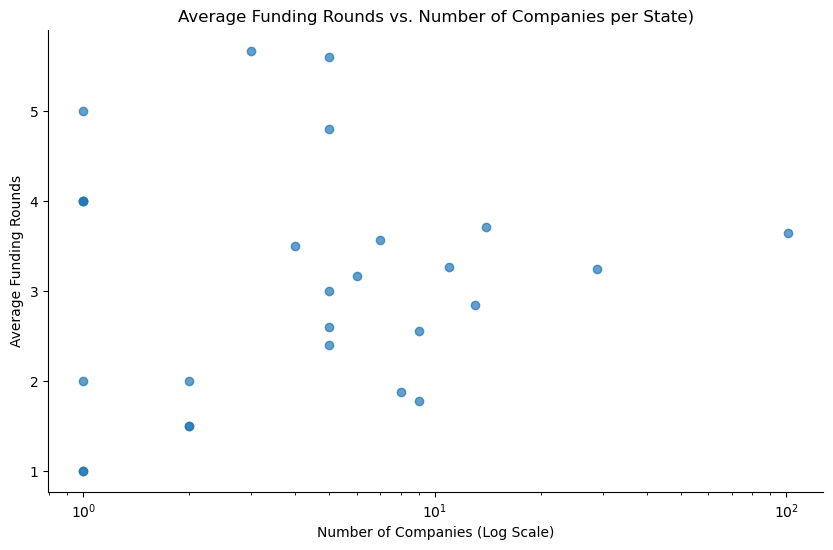

In [55]:
# 1. Scatter Plot – Average Funding Rounds by State 
#filtered_data = summary_table_1[summary_table_1["Num_Companies"] < 100000]  # Adjusted threshold to remove outlier
plt.figure(figsize=(10, 6))
plt.scatter(summary_table_1["Num_Companies"], summary_table_1["Avg_Funding_Rounds"], alpha=0.7)

plt.xscale('log')  # Log scale for the X-axis
plt.yscale('linear')  # Keep Y-axis linear

# Remove the right and top spines
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Labels and title
plt.xlabel("Number of Companies (Log Scale)")
plt.ylabel("Average Funding Rounds")
plt.title("Average Funding Rounds vs. Number of Companies per State)")

plt.show()

The scatter plot above tells the relationship between the number of startups per state and the average funding rounds per state. The trend suggests that states with more startups see a higher and or consistent funding rounds on average. The plot has been ajusted in scale to remove the one outlier identified. This relationship may be as a result of concentration of investors around major states

/var/folders/n_/c5y_3lbx1wv057r6h0z_j_dc0000gn/T/ipykernel_8518/141400077.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_summary = merged.groupby("distance_bin")["Avg_Amt_Raised"].mean().reset_index()


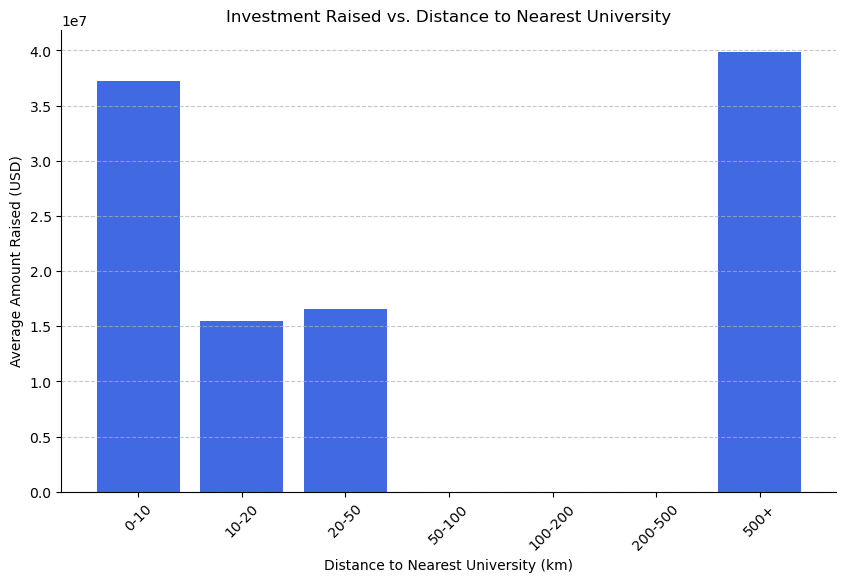

In [57]:
# Define bins for distance ranges
bins = [0, 10, 20, 50, 100, 200, 500, np.inf]  # Distance ranges in km
labels = ["0-10", "10-20", "20-50", "50-100", "100-200", "200-500", "500+"]

# Assign each startup to a distance bin
main['distance_bin'] = pd.cut(main['distance_to_nearest_university'], bins=bins, labels=labels, right=False)

# Merge the startup data with the summary table
merged = main.merge(summary_table_2, on="city", how="left")

# Group by distance bin and compute the average amount raised
distance_summary = merged.groupby("distance_bin")["Avg_Amt_Raised"].mean().reset_index()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(distance_summary["distance_bin"], distance_summary["Avg_Amt_Raised"], color='royalblue')

# Formatting the plot
plt.xlabel("Distance to Nearest University (km)")
plt.ylabel("Average Amount Raised (USD)")
plt.title("Investment Raised vs. Distance to Nearest University")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove the right and top spines
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

The histogram above shows the relationship between proximity and the average investment of startups. This visual is necessary to see if proximity truly influences investment raised. We discover that the highest recorded average occurs within 20 – 50km, whereas the lowest is between 50 to 100 km. This shows that distance may not necessarily have that great of an effect.

/var/folders/n_/c5y_3lbx1wv057r6h0z_j_dc0000gn/T/ipykernel_8518/2486603198.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  funding_summary = merged.groupby("distance_bin")["Avg_Funding_Rounds"].mean().reset_index()


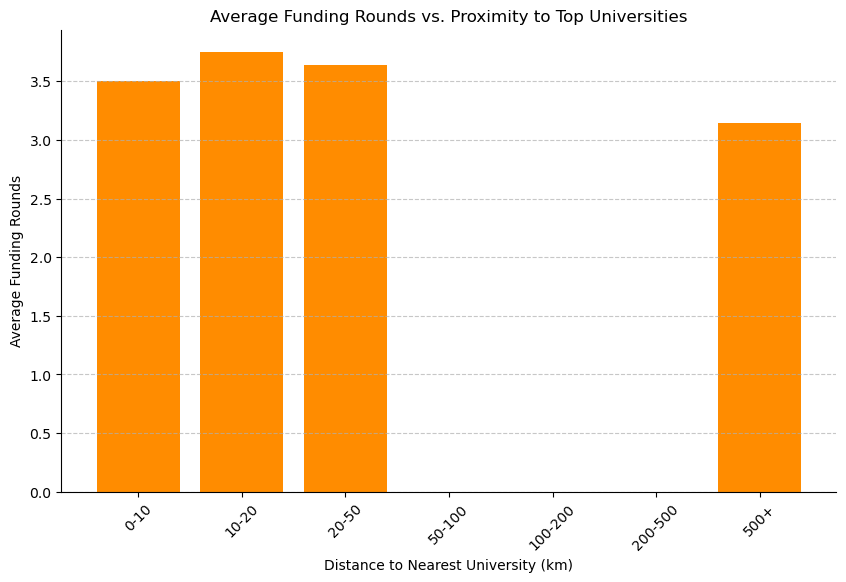

In [59]:
# bins for proximity ranges
bins = [0, 10, 20, 50, 100, 200, 500, np.inf]  # Distance ranges in km
labels = ["0-10", "10-20", "20-50", "50-100", "100-200", "200-500", "500+"]

# Categorize startups into distance bins
main['distance_bin'] = pd.cut(main['distance_to_nearest_university'], bins=bins, labels=labels, right=False)

# Merge startup data with summary_table_1 (state-level funding data)
merged = main.merge(summary_table_1, on="state_code", how="left")

# Group by distance bin and compute the average funding rounds
funding_summary = merged.groupby("distance_bin")["Avg_Funding_Rounds"].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(funding_summary["distance_bin"], funding_summary["Avg_Funding_Rounds"], color='darkorange')

# Remove the right and top spines
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Formatting the plot
plt.xlabel("Distance to Nearest University (km)")
plt.ylabel("Average Funding Rounds")
plt.title("Average Funding Rounds vs. Proximity to Top Universities")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

The bar chart above would help us visualise answers to questions. For example if the funding rounds decline as distance increases, it supports the idea that universities boost startup ecosystems. However this graph shows that funding rounds does not decline. As average funding rounds vary only slightly we can determine that distance may not have much of an effect on funding rounds of startups.

/var/folders/n_/c5y_3lbx1wv057r6h0z_j_dc0000gn/T/ipykernel_8518/42886037.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  funding_vs_distance = merged.groupby("distance_bin").agg(


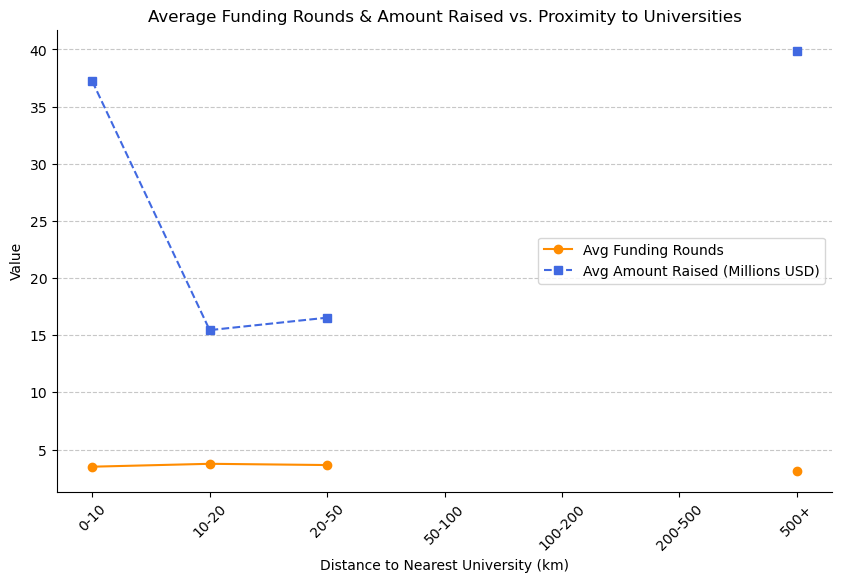

In [61]:
# bins for proximity ranges
bins = [0, 10, 20, 50, 100, 200, 500, np.inf]  # Distance ranges in km
labels = ["0-10", "10-20", "20-50", "50-100", "100-200", "200-500", "500+"]

# Categorize startups into distance bins
main['distance_bin'] = pd.cut(main['distance_to_nearest_university'], bins=bins, labels=labels, right=False)

# Merge startup data with both summary tables
merged = main.merge(summary_table_1, on="state_code", how="left") \
             .merge(summary_table_2, on="city", how="left")

# Group by distance bin and compute the averages
funding_vs_distance = merged.groupby("distance_bin").agg(
    Avg_Funding_Rounds=('Avg_Funding_Rounds', 'mean'),
    Avg_Amt_Raised=('Avg_Amt_Raised', 'mean')
).reset_index()

# Plot the line chart
plt.figure(figsize=(10, 6))

# Plot Avg Funding Rounds
plt.plot(funding_vs_distance["distance_bin"], funding_vs_distance["Avg_Funding_Rounds"], 
         marker="o", linestyle="-", color="darkorange", label="Avg Funding Rounds")

# Plot Avg Amount Raised (normalized for scale)
plt.plot(funding_vs_distance["distance_bin"], funding_vs_distance["Avg_Amt_Raised"] / 1e6, 
         marker="s", linestyle="--", color="royalblue", label="Avg Amount Raised (Millions USD)")

# Formatting the plot
plt.xlabel("Distance to Nearest University (km)")
plt.ylabel("Value")
plt.title("Average Funding Rounds & Amount Raised vs. Proximity to Universities")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove the right and top spines
ax = plt.gca()  # Get current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Mapping

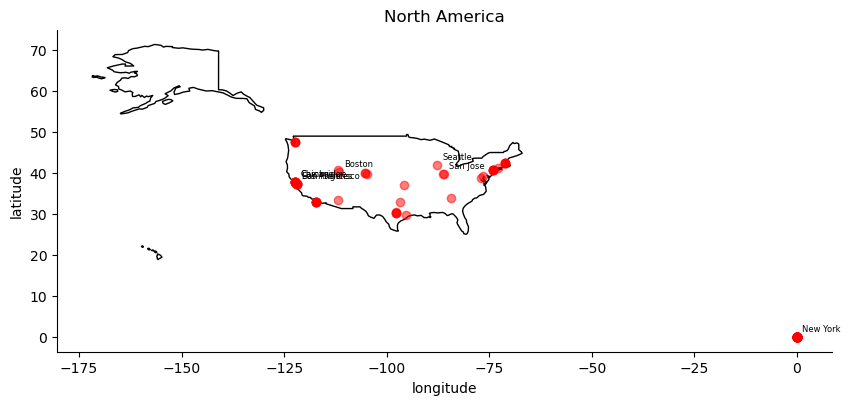

In [63]:
# Read the file
world = gpd.read_file("/Users/jessyterlisner/Desktop/ECO225Project/110m_cultural/ne_110m_admin_0_countries.shp")

main["Coordinates"] = list(zip(main.longitude, main.latitude)) # to create tuples
main["Coordinates"] = main["Coordinates"].apply(Point) # to turn the tuples into a Shapely Point

# Make the geodataframe
gdf = gpd.GeoDataFrame(main, geometry="Coordinates")

# Plotting
world = world.set_index("SOV_A3")

# plot the continent
fig, gax = plt.subplots(figsize=(10,10))

# we only plot America.
world.query("ISO_A3 == 'USA'").plot(ax=gax, edgecolor='black',color='white')

# plot the cities 
gdf.plot(ax=gax, color='red', alpha = 0.5)

# label the cities 
important_cities = ["New York", "San Francisco", "Boston", "Los Angeles", "Chicago", "Seattle", "Cambridge", "San Jose"]

for x, y, label in zip(gdf['Coordinates'].x, gdf['Coordinates'].y, important_cities):
    gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points', fontsize=6)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('North America')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [64]:
# Read the file
#world = gpd.read_file("/Users/jessyterlisner/Desktop/ECO225Project/110m_cultural/ne_110m_admin_0_countries.shp")
#main["Coordinates"] = list(zip(main.longitude, main.latitude)) # to create tuples
#main["Coordinates"] = main["Coordinates"].apply(Point) # to turn the tuples into a Shapely Point

# Make the geodataframe
#gdf = gpd.GeoDataFrame(df_capitals, geometry="Coordinates")

# Plotting
#world = world.set_index("SOV_A3")

# plot the continent
#fig, gax = plt.subplots(figsize=(10,10))

# we only plot Africa.
#world.query("ISO_A3 == 'USA'").plot(ax=gax, edgecolor='black',color='white')

# plot the cities 
#df.plot(ax=gax, color='red', alpha = 0.5)

# label the cities 
#for x, y, label in zip(gdf['Coordinates'].x, gdf['Coordinates'].y, gdf['Capital City']):
    #gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')

#ax.set_xticks([])
#ax.set_yticks([])
#gax.set_title('Average Funding Rounding Per State')
#ax.set_frame_on(False)

# Add a separate axis for the color bar
#cax = fig.add_axes([0.92, 0.3, 0.02, 0.5])

# Create color bar
#sm = plt.cm.ScalarMappable(cmap="Blues", norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
#cbar = fig.colorbar(sm, cax=cax)
#cbar.ax.set_ylabel('Average Funding Rounding', fontsize = 12)

## ####

# Load the U.S. states shapefile (not the world map!)
#us_states = gpd.read_file("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json")

# Read startup funding data (Ensure it contains 'state' and 'funding_rounds')
#main = pd.read_csv("/Users/jessyterlisner/Desktop/ECO225Project/startups.csv")  # Adjust the path

# Convert state abbreviations to uppercase for merging
#main["state"] = main["state"].str.upper()

# Calculate average funding rounds per state
#state_funding = main.groupby("state")["funding_rounds"].mean().reset_index()

# Rename columns for merging
#state_funding = state_funding.rename(columns={"state": "NAME"})

# Merge with the U.S. states GeoDataFrame
#map_data = us_states.merge(state_funding, on="NAME", how="left")

# Set up figure
#fig, ax = plt.subplots(figsize=(12, 8))

# Plot the map with funding rounds
#map_data.plot(column="funding_rounds", cmap="Blues", linewidth=0.8, edgecolor="black", legend=True,
 #             vmin=0, vmax=2.5, ax=ax)

# Remove axes ticks and labels
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_title('Average Funding Rounds Per State', fontsize=14)

# Adjust layout to fit legend better
#plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1)

#plt.show()


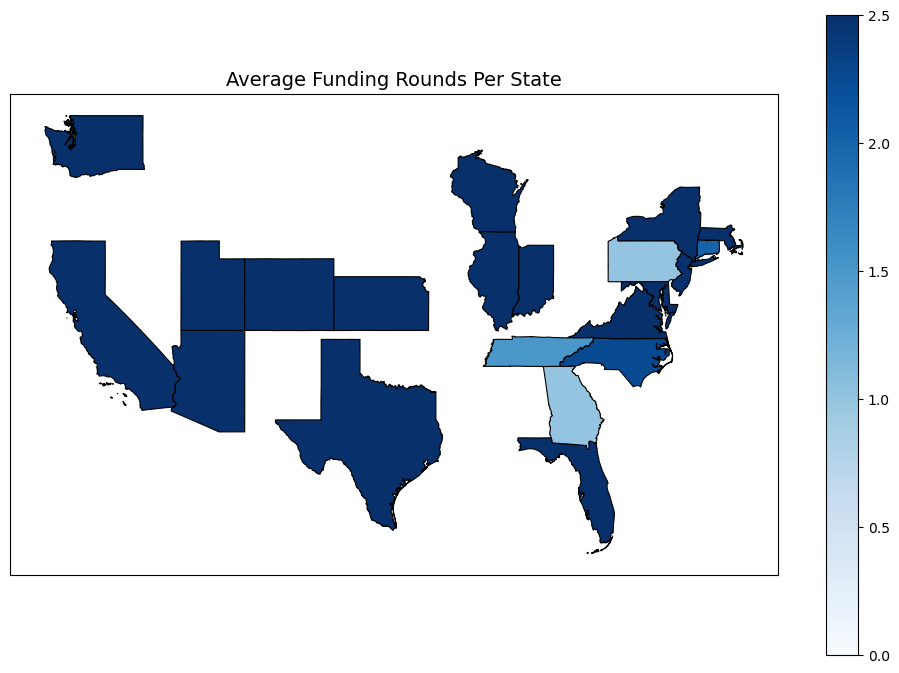

In [65]:
# Load the U.S. states shapefile 
us_states = gpd.read_file("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json")

# Convert state abbreviations to uppercase for merging
main["state_code"] = main["state_code"].str.upper()

# Calculate average funding rounds per state
state_funding = main.groupby("state_code")["funding_rounds"].mean().reset_index()

# Rename columns for merging
state_funding = state_funding.rename(columns={"state_code": "NAME"})

state_funding["NAME"] = state_funding["NAME"].map(lambda x: us.states.lookup(x).name if us.states.lookup(x) else x)

# Merge with the U.S. states GeoDataFrame
map_data = us_states.merge(state_funding, on="NAME", how="left")

# Set up figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the map with funding rounds
map_data.plot(column="funding_rounds", 
              cmap="Blues", 
              linewidth=0.8, 
              edgecolor="black", 
              legend=True,
              vmin=0, vmax=2.5,
              ax=ax)

# Remove axes ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Funding Rounds Per State', fontsize=14)

# Adjust layout to fit legend better
plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1)

# Show the plot
plt.show()


In [66]:
print(us_states.columns)
us_states.head()

Index(['GEO_ID', 'STATE', 'NAME', 'LSAD', 'CENSUSAREA', 'geometry'], dtype='object')


,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.6065, -70.82374 4..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11578, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.0577 44.99743, -104.25014 44.99..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.0506 37.0004, -114.05 36.95777,..."


This line graph shows the relationship between distance, average funding rounds and average amounts raised. It is important to know if higher average funding rounds is positively correlated to the average amount raised and it is important to see what role distance plays. For example between 50- 100km is the highest average funding round however it is also the lowest average amount raised range. 

### Regressions

In [69]:
reg_main = pd.DataFrame()
# Convert category_code into categorical type
reg_main['Industry'] = main['category_code'].astype('category')

# Convert date columns to datetime
date_cols = ['funded_at', 'founded_at', 'first_investment_at', 'first_funding_at', 'public_at']
for col in date_cols:
    main[col] = pd.to_datetime(main[col], errors='coerce')  # Convert strings to datetime, force invalid ones to NaT

# Calculate startup age at funding round
reg_main['Startup_Age'] = (main['funded_at'] - main['founded_at']).dt.days / 365.25  # Convert days to years

# Calculate time to first investment
reg_main['Time_To_First_Investment'] = (main['first_investment_at'] - main['founded_at']).dt.days / 365.25

# Calculate time to first funding
reg_main['Time_To_First_Funding'] = (main['first_funding_at'] - main['founded_at']).dt.days / 365.25

# Total funding raised per startup
reg_main['Total_Funding_USD'] = main.groupby('category_code')['raised_amount_usd'].transform('sum')

# Count of funding rounds per startup
reg_main['Total_Funding_Rounds'] = main.groupby('category_code')['funded_at'].transform('count')

# Binary indicator for IPO success
reg_main['IPO_Success'] = np.where(main['public_at'].notnull(), 1, 0)

# Convert funding round type to categorical
reg_main['Funding_Round_Type'] = main['funding_round_type'].astype('category')

# Average investor participation per startup
reg_main['Avg_Participants_Per_Round'] = main.groupby('category_code')['participants'].transform('mean')

# Convert all relevant variables to numeric
for col in ['Startup_Age', 'Total_Funding_USD',
            'Total_Funding_Rounds', 'IPO_Success', 'Avg_Participants_Per_Round']:
    reg_main[col] = pd.to_numeric(reg_main[col], errors='coerce')

# Convert all values to numeric, coercing errors to NaN
reg_main = reg_main.apply(pd.to_numeric, errors='coerce')

# Drop missing values
reg_main = reg_main.dropna(subset=['Startup_Age', 'Total_Funding_USD','Total_Funding_Rounds', 
                                   'IPO_Success', 'Avg_Participants_Per_Round'])

# Define dependent variable (Y): Post-money valuation (proxy for startup success)
Y = reg_main['Total_Funding_USD']

# Define independent variables (X)
X = reg_main[['Startup_Age', 'Total_Funding_USD', 'Total_Funding_Rounds', 'IPO_Success', 'Avg_Participants_Per_Round']]

# Add industry dummies and drop the first category to avoid multicollinearity
X = pd.get_dummies(reg_main[['Startup_Age', 'Total_Funding_USD', 'Total_Funding_Rounds', 
                             'IPO_Success', 'Avg_Participants_Per_Round']].join(reg_main['Industry']), 
                   drop_first=True)

# Fill NaNs with 0
X = X.fillna(0)

# Add constant term
X = sm.add_constant(X)

# Create lists of variables to be used in each regression
X1 = X2 = X[['const', 'Startup_Age']]
X2 = X[['const', 'Startup_Age', 'Total_Funding_Rounds']]
X3 = X[['const', 'Startup_Age','Total_Funding_Rounds', 'IPO_Success']]
X4 = X[['const', 'Startup_Age','Total_Funding_Rounds', 'IPO_Success', 'Avg_Participants_Per_Round']]

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(Y, X1, missing='drop').fit()
reg2 = sm.OLS(Y, X2, missing='drop').fit()
reg3 = sm.OLS(Y, X3, missing='drop').fit()
reg4 = sm.OLS(Y, X4, missing='drop').fit()

# Display the Regression Results using Stargazer
stargazer = Stargazer([reg1, reg2 , reg3, reg4])

# Set the same order of variables for all regressions
stargazer.covariate_order(['Startup_Age', 'Total_Funding_Rounds', 'IPO_Success', 'Avg_Participants_Per_Round'])
stargazer.title("Regression Results: Investment")
stargazer.custom_columns(["reg1","reg2", "reg3", "reg4"], [1 , 1, 1, 1])

# Output the HTML representation of the regression table
html_output = stargazer.render_html()
display(HTML(html_output))

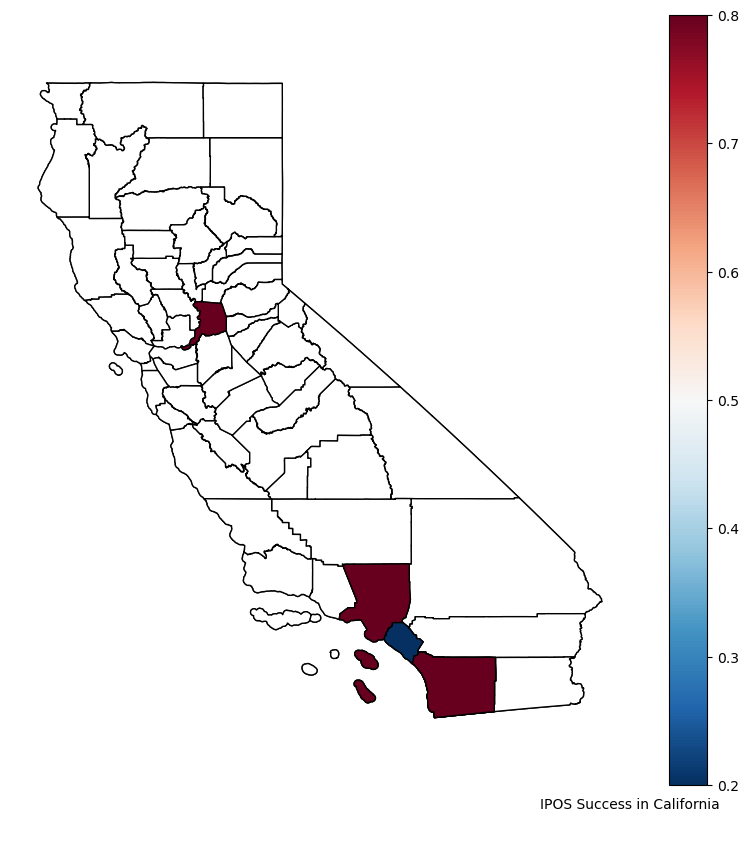

In [75]:
# Load the U.S. states shapefile 
state_ca = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip")

# Load the U.S. county shapefile 
county_ca = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip")
county_ca = county_ca.query("STATEFP == '06'") 

county_ca["NAME"] = county_ca["NAME"].str.title().str.strip()
reg_main["region"] = main["region"].str.title().str.strip()

ca_merge = county_ca.merge(reg_main, left_on="NAME", right_on="region", how="inner")

fig, gax = plt.subplots(figsize=(10, 10))
state_ca.query("NAME == 'California'").plot(ax=gax, edgecolor="black", color="white")
county_ca.plot(ax=gax, edgecolor="black", color="white")

# Plot the counties and the ipos success
ca_merge.plot(
    ax=gax, edgecolor='black', column='IPO_Success', legend=True, cmap='RdBu_r',
    vmin=0.2, vmax=0.8)

# Add text to let people know what we are plotting
gax.annotate('IPOS Success in California',xy=(0.54, 0.05),  xycoords='figure fraction')

# I don't want the axis with long and lat
plt.axis('off')

plt.show()



In [ ]:
#reg_main = main[["funding_rounds", "distance_to_nearest_university"]]

# Add constant term to dataset
#reg_main['const'] = 1

# Create lists of variables to be used in each regression
#X1 = ["const", "distance_to_nearest_university"]
# X2 = ["const", "distance_to_nearest_university", 'lat_abst']

# Estimate an OLS regression for each set of variables
#reg1 = sm.OLS(reg_main["funding_rounds"], reg_main[X1], missing='drop').fit()

#stargazer = Stargazer([reg1])
#stargazer.custom_columns(["funding_rounds"],[1])
#HTML(stargazer.render_html())

### Conclusion
To conclude, from the literature review and the data presented, we see that location decisions are important for startups. The scatter plot showed that being located in high-density startup locations provides room for higher average funding rounds than being in a low-density startup location. Further analysis is needed to look fully at the role of proximity to elite universities.

### References
Anselin, L., Varga, A., & Acs, Z. (1997). Local Geographic Spillovers between University Research and High Technology Innovations. Journal of Urban Economics, 42(3), 422-448.

Audretsch, D. B., Lehmann, E. E., & Warning, S. (2005). University spillovers and new firm location. Research Policy, 34(7), 1113–1122.

Baptista, R., Mendonça, J. Proximity to knowledge sources and the location of knowledge-based start-ups. Ann Reg Sci 45, 5–29 (2010).

Bonaccorsi, A., Colombo, M.G., Guerini, M. et al. University specialization and new firm creation across industries. Small Bus Econ 41, 837–863 (2013).

Fritsch, M., & Aamoucke, R. (2017). Fields of knowledge in higher education institutions, and innovative start‐ups: An empirical investigation. Papers in Regional Science, 96, S1-S28.